In [1]:
import numpyro
import numpyro.distributions as dist
import jax.numpy as jnp
from numpyro.infer import MCMC, NUTS

def complex_mvn_logpdf(z, Gamma):
    """Log-pdf for z ~ CN(0, Gamma), z: (L, K), Gamma: (K, K) Hermitian"""
    L, K = z.shape
    Gamma_inv = jnp.linalg.inv(Gamma)
    sign, logdet = jnp.linalg.slogdet(Gamma)

    # z: (L, K), Gamma_inv: (K, K)
    # Compute quadratic form for each row: zᵢᴴ Γ⁻¹ zᵢ
    quad = jnp.real(jnp.einsum("bi,ij,bj->b", jnp.conj(z), Gamma_inv, z))  # shape (L,)

    return -K * jnp.log(jnp.pi) - logdet - quad

In [2]:
import numpy as np

def simulate_cscn_data(K=3, n_samples=500, seed=0):
    rng = np.random.default_rng(seed)

    # Random low-rank complex A
    r = K
    A = rng.normal(0, 1, size=(K, r)) + 1j * rng.normal(0, 1, size=(K, r))

    # Hermitian PSD
    Gamma = A @ A.conj().T + 0.5 * np.eye(K)

    from scipy.linalg import cholesky
    L = cholesky(Gamma, lower=True)

    # Standard complex normals
    z_std_normal = rng.normal(size=(n_samples, K)) + 1j * rng.normal(size=(n_samples, K))

    # Correct sampling
    z_samples = (L @ z_std_normal.T) / np.sqrt(2)  # shape (K, n_samples)
    z_samples = z_samples.T  # shape (n_samples, K)

    return z_samples, Gamma

z_obs, Gamma_true = simulate_cscn_data(K=5, n_samples=100)


In [3]:
# Empirical covariance
Gamma_emp = np.einsum("li,lj->ij", z_obs, np.conj(z_obs)) / z_obs.shape[0]

# Eigendecomposition (since Gamma_emp is Hermitian)
eigvals, U = np.linalg.eigh(Gamma_emp)  # U ∈ ℂ^{K×K}


In [4]:
z_obs.shape

(100, 5)

In [5]:
import jax
import jax.numpy as jnp
from jax import grad, jit
from jax.scipy.linalg import cho_solve, cholesky
import optax

def empirical_covariance(Z):
    """Estimate empirical covariance for complex data."""
    return Z.conj().T @ Z / Z.shape[0]

def loss_fn(L_flat, d, S, beta):
    """Penalized negative log-likelihood for complex Hermitian covariance."""
    # Reconstruct lower-triangular complex matrix L
    L = L_flat.reshape(d, d)
    
    # Gamma = L @ L.H
    Gamma = L @ L.conj().T

    # logdet(Gamma) = 2 * sum(log(real(diag(L))))
    diag_L = jnp.real(jnp.diag(L))
    logdet = 2.0 * jnp.sum(jnp.log(diag_L + 1e-8))  # stability

    # trace(Gamma^{-1} @ S)
    # Solve using cholesky-based solver
    inv_Gamma_S = cho_solve((L, True), S)

    trace_term = jnp.real(jnp.trace(inv_Gamma_S))

    # Total loss
    return (beta + S.shape[0]) * logdet + S.shape[0] * trace_term

@jit
def optimize_map_estimator(Z, beta=1.0, num_steps=50, lr=1e-2):
    """MAP estimator for complex Gaussian covariance using -logdet penalty."""
    N, d = Z.shape
    S = empirical_covariance(Z)

    # Initialize with Cholesky of S
    L_init = cholesky(S + 1e-6 * jnp.eye(d), lower=True)

    # Flatten for optimization
    L_flat = L_init.reshape(-1)

    # Optimizer
    opt = optax.adam(lr)
    opt_state = opt.init(L_flat)

    def step(step_i, state):
        L_flat, opt_state = state
        loss, grads = jax.value_and_grad(loss_fn)(L_flat, d, S, beta)
        updates, opt_state = opt.update(grads, opt_state)
        L_flat = optax.apply_updates(L_flat, updates)
        return (L_flat, opt_state), loss

    state = (L_flat, opt_state)
    for i in range(num_steps):
        state, loss = step(i, state)
        if i % 50 == 0:
            print(i)
            print(loss)
            # print(f"Step {i}, Loss: {loss:.4f}")

    print('DONE')
    # Reconstruct final Gamma
    L_opt = state[0].reshape(d, d)
    print('A')
    Gamma_opt = L_opt @ L_opt.conj().T
    print('B')
    return Gamma_opt


In [6]:
# Simulate complex Gaussian data
key = jax.random.PRNGKey(0)
# N, d = 100, 5
# true_cov = jnp.diag(jnp.array([3.0, 2.0, 1.0, 0.1, 0.05]))
# Z = jax.random.multivariate_normal(key, jnp.zeros(d), true_cov, shape=(N,)) + \
#     1j * jax.random.multivariate_normal(key, jnp.zeros(d), true_cov, shape=(N,))
true_cov = jnp.array([
    [2.0, 0.8 + 0.5j, 0.0],
    [0.8 - 0.5j, 1.5, -0.3 + 0.4j],
    [0.0, -0.3 - 0.4j, 1.0]
])
N, d = 100, true_cov.shape[0]
L = jnp.linalg.cholesky(true_cov)
real_part = jax.random.normal(key, (N, d))
imag_part = jax.random.normal(key + 1, (N, d))
Z = (real_part + 1j * imag_part) @ L.T

# Estimate with SVS-style MAP
Gamma_hat = optimize_map_estimator(Z, beta=500.0)


0
Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>
DONE
A
B


In [7]:
Gamma_hat

Array([[ 1.9442099e+00+0.j        ,  1.3106389e+00-1.5334909j ,
        -5.3014743e-01-0.75065994j],
       [ 1.3106389e+00+1.5334909j ,  2.8784201e+00+0.j        ,
         1.1179149e-03-2.0042584j ],
       [-5.3014743e-01+0.75065994j,  1.1179447e-03+2.0042584j ,
         2.5548391e+00+0.j        ]], dtype=complex64)

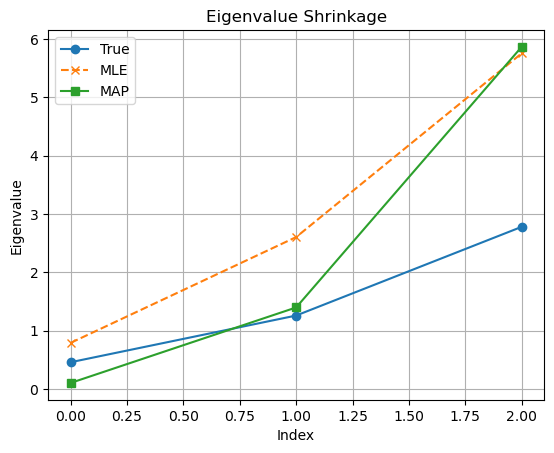

In [8]:
# MLE
Gamma_mle = Z.conj().T @ Z / N

# MAP estimate
Gamma_map = optimize_map_estimator(Z, beta=5e10)

# Compare eigenvalues
eig_mle = jnp.linalg.eigvalsh(Gamma_mle)
eig_map = jnp.linalg.eigvalsh(Gamma_map)
eig_true = jnp.linalg.eigvalsh(true_cov)

import matplotlib.pyplot as plt
plt.plot(eig_true, 'o-', label='True')
plt.plot(eig_mle, 'x--', label='MLE')
plt.plot(eig_map, 's-', label='MAP')
plt.ylabel("Eigenvalue")
plt.xlabel("Index")
plt.legend()
plt.title("Eigenvalue Shrinkage")
plt.grid(True)
plt.show()


In [9]:
# Next - let's pull up some 'alphas' from saved models and see how estimate behaves in those cases
# Really though, we need to understand how having a prior interacts with the full M-Step in our algorithm, which should be next focus pom 

In [10]:
from cohlib.utils import pickle_open
import cohlib.confs.utils as conf
gseed_use = 0
seed_use = 0
# temp = "/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_rank1/window1000/gseed0/K3/L5/lseed0/obs-pp_log/mu0.8/oseed0/model-simple_inherit_latent_fullrank/inherit-True/m_step-full-rank-standard/empirical-init/newton-10_em-20/res.pkl"
# temp = "/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_rank1/scale1000000/window1000/gseed0/K3/L5/lseed0/obs-pp_log/mu0.8/oseed0/model-simple_inherit_latent_fullrank_pinv/inherit-True/m_step-full-rank-standard/empirical-init/newton-10_em-20/res.pkl"
scale_power = int(5e4)
mu = 2.3
temp = f"/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_rank1/scale{scale_power}/window1000/gseed0/K5/L25/lseed0/obs-pp_log/mu{mu}/oseed0/model-simple_inherit_latent_fullrank_pinv/inherit-True/m_step-full-rank-standard/empirical-init/newton-10_em-20/res.pkl"
res = pickle_open(temp)
cfg = conf.omega(res['cfg'])

cfg.latent.gamma_seed = gseed_use
cfg.latent.seed = seed_use
cfg.obs.seed = seed_use
nz_model = jnp.array([cfg.latent.target_freq_ind])

In [11]:
res['track'].keys()

dict_keys(['ccn', 'alphas', 'Upss'])

In [169]:
r = 1
alphas = res['track']['alphas'][r]
Upss = res['track']['Upss'][r]

In [170]:
def m_step_loss(L_flat, d, Sigma_sum, beta, L_count):
    """Penalized loss for a single Gamma_j in the EM M-step."""
    L = L_flat.reshape(d, d)
    Gamma = L @ L.conj().T
    diag_L = jnp.real(jnp.diag(L))
    logdet = 2.0 * jnp.sum(jnp.log(diag_L + 1e-8))

    trace_term = jnp.real(jnp.trace(jnp.linalg.solve(Gamma, Sigma_sum)))

    return (L_count + beta) * logdet + trace_term


In [171]:
@jit
def m_step_optimizer(init, alphas, Upss, beta=1.0, num_steps=500, lr=1e-2):
    """MAP estimator for complex Gaussian covariance using -logdet penalty."""
    N, d = Z.shape
    S = empirical_covariance(Z)

    # Initialize with Cholesky of S
    L_init = cholesky(S + 1e-6 * jnp.eye(d), lower=True)

    # Flatten for optimization
    L_flat = L_init.reshape(-1)

    # Optimizer
    opt = optax.adam(lr)
    opt_state = opt.init(L_flat)

    def step(step_i, state):
        L_flat, opt_state = state
        loss, grads = jax.value_and_grad(loss_fn)(L_flat, d, S, beta)
        updates, opt_state = opt.update(grads, opt_state)
        L_flat = optax.apply_updates(L_flat, updates)
        return (L_flat, opt_state), loss

    state = (L_flat, opt_state)
    for i in range(num_steps):
        state, loss = step(i, state)
        if i % 50 == 0:
            print(f"Step {i}, Loss: {loss:.4f}")

    # Reconstruct final Gamma
    L_opt = state[0].reshape(d, d)
    Gamma_opt = L_opt @ L_opt.conj().T
    return Gamma_opt

In [172]:
def optimize_map_m_step(Sigma_sum, L_count, L_prev=None, beta=1.0, num_steps=500, lr=1e-2):
    """
    Perform MAP optimization for a complex Hermitian covariance matrix Gamma,
    using a Cholesky-factor parameterization and a log-det prior (SVS).

    Args:
        Sigma_sum: array (d, d), sum of expected outer products: sum_ell E[z z^H]
        L_prev: optional (d, d) complex Cholesky factor of previous Gamma (for warm start)
        beta: scalar, strength of log-det penalty (prior)
        num_steps: int, number of optimization steps
        lr: learning rate for optimizer

    Returns:
        Gamma_opt: (d, d) optimized Hermitian PSD covariance matrix
    """
    import optax
    import jax
    import jax.numpy as jnp
    from jax import jit, value_and_grad
    from jax.scipy.linalg import cho_solve, cholesky

    d = Sigma_sum.shape[0]

    # Initialize L
    if L_prev is None:
        # Identity init
        L_init = jnp.eye(d, dtype=jnp.complex64)
    else:
        L_init = L_prev

    L_flat = L_init.reshape(-1)

    # Loss function
    def loss_fn(L_flat):
        L = L_flat.reshape(d, d)
        Gamma = L @ L.conj().T
        diag_L = jnp.real(jnp.diag(L))
        logdet = 2.0 * jnp.sum(jnp.log(diag_L + 1e-8))  # ensure numerical stability
        trace_term = jnp.real(jnp.trace(jnp.linalg.solve(Gamma, Sigma_sum)))
        return (L_count + beta) * logdet + trace_term

    # Optimizer setup
    opt = optax.adam(lr)
    opt_state = opt.init(L_flat)

    @jit
    def step(state):
        L_flat, opt_state = state
        loss, grads = value_and_grad(loss_fn)(L_flat)
        updates, opt_state = opt.update(grads, opt_state)
        L_flat = optax.apply_updates(L_flat, updates)
        return (L_flat, opt_state), loss

    state = (L_flat, opt_state)

    for i in range(num_steps):
        state, loss = step(state)
        if i % 50 == 0:
            print(f"Step {i}, Loss: {loss:.4f}")

    L_opt = state[0].reshape(d, d)
    Gamma_opt = L_opt @ L_opt.conj().T
    return Gamma_opt

# NEXT: try using Newton's method hard-coded as we previously developed

In [173]:
def optimize_map_m_step_alt(Sigma_sum, L_count, L_prev=None, beta=1.0, num_iters=10, lr=1e-2):
    """
    Perform MAP optimization for a complex Hermitian covariance matrix Gamma,
    using a Cholesky-factor parameterization and a log-det prior (SVS).

    Args:
        Sigma_sum: array (d, d), sum of expected outer products: sum_ell E[z z^H]
        L_prev: optional (d, d) complex Cholesky factor of previous Gamma (for warm start)
        beta: scalar, strength of log-det penalty (prior)
        num_steps: int, number of optimization steps
        lr: learning rate for optimizer

    Returns:
        Gamma_opt: (d, d) optimized Hermitian PSD covariance matrix
    """
    import optax
    import jax
    import jax.numpy as jnp
    from jax import jit, value_and_grad
    
    from jax.scipy.linalg import cho_solve, cholesky

    d = Sigma_sum.shape[0]

    # Initialize L
    if L_prev is None:
        # Identity init
        L_init = jnp.eye(d, dtype=jnp.complex64)
    else:
        L_init = L_prev

    L_flat = L_init.reshape(-1)

    # Loss function
    def loss_fn(L_flat):
        L = L_flat.reshape(d, d)
        Gamma = L @ L.conj().T
        diag_L = jnp.real(jnp.diag(L))
        logdet = 2.0 * jnp.sum(jnp.log(diag_L + 1e-8))  # ensure numerical stability
        trace_term = (jnp.trace(jnp.linalg.solve(Gamma, Sigma_sum)))
        return (L_count + beta) * logdet + trace_term


    cost_grad = jax.jit(jax.grad(loss_fn, holomorphic=True))
    cost_hess = jax.jit(jax.hessian(loss_fn, holomorphic=True))


    L_flat_est = L_flat
    for _ in range(num_iters):
        L_flat_hess = cost_hess(L_flat_est)
        print(L_flat_hess.shape)
        L_flat_grad = cost_grad(L_flat_est).conj()
        # hess_sel = jnp.stack([L_flat_hess[n,:,n,:] for n in range(Nnz)]).conj()
        L_flat_est, L_flat_hess_inv = newton_step(L_flat_est, L_flat_grad, L_flat_hess)

    L_opt = L_flat_est.reshape(d, d)
    Gamma_opt = L_opt @ L_opt.conj().T
    return Gamma_opt

# NEXT: try using Newton's method hard-coded as we previously developed
@jax.jit
def newton_step(vec_est, vec_grad, hess):
    # TODO finish note
    # NOTE Jax gives us a gradient and Hessian - we need to take the
    # conjugate of both when using Newton's method
    hess_inv = jnp.linalg.inv(hess)

    vec_est = vec_est - jnp.einsum('ki,i->k', hess_inv, vec_grad)

    return vec_est, hess_inv 

In [176]:
test = optimize_map_m_step_alt(Sigmas_sum, L_count, L_prev=L_prev_test, beta=1, num_iters=2)

(25, 25)
(25, 25)


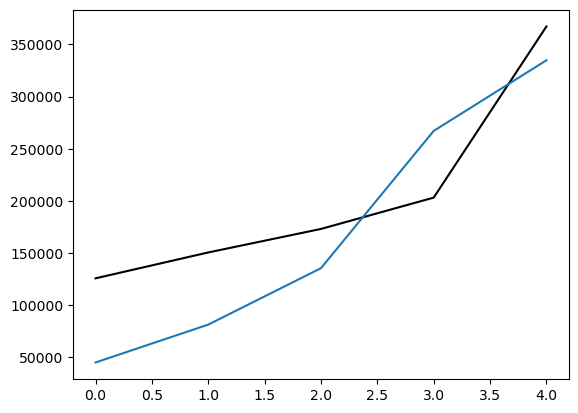

In [177]:
plt.plot(jnp.linalg.eigh(gamma_update)[0].squeeze(), color='k')
plt.plot(jnp.linalg.eigh(test)[0].squeeze(), color='tab:blue')

In [158]:
def m_step_fullrank(alphas_outer, Upss, options=None):
    return (alphas_outer + Upss).mean(-1)

alphas_outer = jnp.einsum('nkl,nil->nkil', alphas, alphas.conj())
gamma_update = m_step_fullrank(alphas_outer, 2*Upss)

In [159]:
gamma_update

Array([[[215748.47  +4.3300565e+02j, -30763.305 +5.2150936e+01j,
           7549.356 +3.2306354e+04j, -20020.01  -5.0202277e+04j,
          25287.445 -2.4005010e+03j],
        [-30762.78  -5.2844063e+01j, 194838.92  +1.5772354e+02j,
         -20542.598 -5.2113320e+04j,  19477.39  +3.9606750e+04j,
         -34939.96  -3.6731475e+03j],
        [  7550.416 -3.2306930e+04j, -20543.637 +5.2112699e+04j,
         203053.3   +7.9275742e+01j, -44108.203 -1.4011739e+04j,
          -6101.773 -5.4776625e+04j],
        [-20017.422 +5.0203582e+04j,  19475.79  -3.9608684e+04j,
         -44105.625 +1.4013407e+04j, 219793.16  -8.6573938e+02j,
           3873.3037+2.7408250e+04j],
        [ 25287.992 +2.4016560e+03j, -34945.02  +3.6699756e+03j,
          -6110.2935+5.4773141e+04j,   3873.1758-2.7408295e+04j,
         186301.08  +7.8044061e+02j]]], dtype=complex64)

In [85]:
gamma_update

Array([[[215748.47  +4.3300565e+02j, -30763.305 +5.2150936e+01j,
           7549.356 +3.2306354e+04j, -20020.01  -5.0202277e+04j,
          25287.445 -2.4005010e+03j],
        [-30762.78  -5.2844063e+01j, 194838.92  +1.5772354e+02j,
         -20542.598 -5.2113320e+04j,  19477.39  +3.9606750e+04j,
         -34939.96  -3.6731475e+03j],
        [  7550.416 -3.2306930e+04j, -20543.637 +5.2112699e+04j,
         203053.3   +7.9275742e+01j, -44108.203 -1.4011739e+04j,
          -6101.773 -5.4776625e+04j],
        [-20017.422 +5.0203582e+04j,  19475.79  -3.9608684e+04j,
         -44105.625 +1.4013407e+04j, 219793.16  -8.6573938e+02j,
           3873.3037+2.7408250e+04j],
        [ 25287.992 +2.4016560e+03j, -34945.02  +3.6699756e+03j,
          -6110.2935+5.4773141e+04j,   3873.1758-2.7408295e+04j,
         186301.08  +7.8044061e+02j]]], dtype=complex64)

In [73]:
L_prev_test = jnp.linalg.cholesky(gamma_update.squeeze())

In [74]:
Sigmas = (alphas_outer + Upss).squeeze()
Sigmas_sum = Sigmas.sum(2)
L_count = Sigmas.shape[2]

In [75]:
L_prev_test.shape

(5, 5)

In [76]:
jnp.diag(L_prev_test)

Array([464.4873 +0.j, 436.40863+0.j, 429.08157+0.j, 440.64722+0.j,
       407.98236+0.j], dtype=complex64)

In [106]:
test = optimize_map_m_step(Sigmas_sum, L_count, L_prev=L_prev_test, beta=10, num_steps=1000, lr=1e-2)

Step 0, Loss: 2220.3416
Step 50, Loss: 2220.1670
Step 100, Loss: 2219.9919
Step 150, Loss: 2219.8162
Step 200, Loss: 2219.6404
Step 250, Loss: 2219.4644
Step 300, Loss: 2219.2883
Step 350, Loss: 2219.1130
Step 400, Loss: 2218.9377
Step 450, Loss: 2218.7625
Step 500, Loss: 2218.5876
Step 550, Loss: 2218.4128
Step 600, Loss: 2218.2385
Step 650, Loss: 2218.0637
Step 700, Loss: 2217.8896
Step 750, Loss: 2217.7156
Step 800, Loss: 2217.5415
Step 850, Loss: 2217.3679
Step 900, Loss: 2217.1943
Step 950, Loss: 2217.0212


In [100]:
gamma_update - test

Array([[[ 8813.594    +433.00565j,   208.72852  +780.6589j ,
           541.4487  +2286.3613j ,  -633.5215   -850.23047j,
          -585.6738  +1511.167j  ],
        [  209.2539   -781.352j  ,  6735.5312   +157.72354j,
           443.0664   -822.4961j , -1033.543   -2476.6484j ,
          1738.8086  -1344.3818j ],
        [  542.5088  -2286.9375j ,   442.02734  +821.875j  ,
         10663.5       +79.27574j, -2452.289   -2110.8057j ,
           235.8125   +340.60156j],
        [ -630.9336   +851.53516j, -1035.1445  +2474.7148j ,
         -2449.711   +2112.4736j ,  8806.297    -865.7394j ,
           641.2859 -12400.875j  ],
        [ -585.125   -1510.012j  ,  1733.7461  +1341.21j   ,
           227.2915   -344.08594j,   641.15796+12400.83j   ,
          5575.5156   +780.4406j ]]], dtype=complex64)

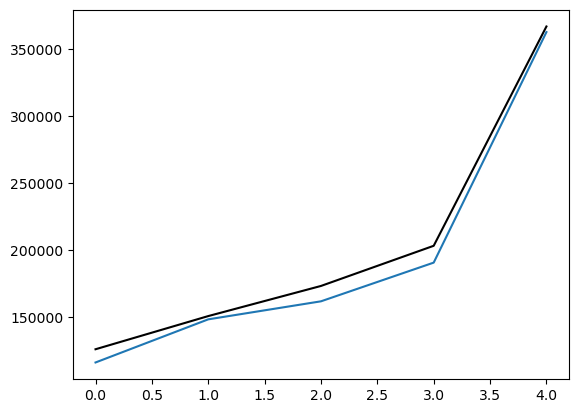

In [96]:
plt.plot(jnp.linalg.eigh(gamma_update)[0].squeeze(), color='k')
plt.plot(jnp.linalg.eigh(test)[0].squeeze(), color='tab:blue')

In [86]:
test

Array([[207230.77      +0.j    , -30996.238   -741.759j ,
          7007.8022+30040.098j , -19395.834 -49388.93j  ,
         25892.219  -3903.9873j],
       [-30996.238   +741.759j , 188301.17      +0.j    ,
        -20990.39  -51319.664j ,  20518.1   +42102.902j ,
        -36695.02   -2337.7554j],
       [  7007.8022-30040.098j , -20990.39  +51319.664j ,
        192732.2       +0.j    , -41678.996 -11927.6j   ,
         -6338.8516-55154.953j ],
       [-19395.834 +49388.93j  ,  20518.1   -42102.902j ,
        -41678.996 +11927.6j   , 211359.73      +0.j    ,
          3232.0605+39823.457j ],
       [ 25892.219  +3903.987j , -36695.02   +2337.7554j,
         -6338.852 +55154.953j ,   3232.06  -39823.457j ,
        180979.7       +0.j    ]], dtype=complex64)

In [7]:
K = 5
-5 + (3*jnp.arange(K)[::-1])

Array([ 7,  4,  1, -2, -5], dtype=int32)

In [8]:
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist

def model_qr(z_obs):
    L, K = z_obs.shape
    # key = numpyro.sample("qr_key", dist.PRNGIdentity())  # for reproducibility

    # Sample unconstrained complex matrix B0
    B0_real = numpyro.sample("B0_real", dist.Normal(0, 1).expand([K, K]))
    B0_imag = numpyro.sample("B0_imag", dist.Normal(0, 1).expand([K, K]))
    B0 = B0_real + 1j * B0_imag

    # QR decomposition to get orthonormal Q
    Q, _ = jnp.linalg.qr(B0)  # Q has orthonormal columns

    # Sparse prior on eigenvalues (log-normal form)
    log_lambda = numpyro.sample("log_lambda", dist.Normal(-5.0 - 2.0 * jnp.arange(K), 0.5))
    lambdas = jnp.exp(log_lambda)
    D = jnp.diag(lambdas)

    # Construct complex Hermitian covariance matrix
    Gamma = Q @ D @ Q.conj().T

    # Log-likelihood using custom complex MVN
    logp = complex_mvn_logpdf(z_obs, Gamma)  # <-- your own implementation
    numpyro.factor("likelihood", jnp.sum(logp))

In [9]:
import jax.numpy as jnp

def model_with_orthogonality_penalty(z_obs, alpha=10.0):
    L, K = z_obs.shape

    # Sample complex matrix B = B_real + i B_imag
    B_real = numpyro.sample("B_real", dist.Normal(0, 1).expand([K, K]))
    B_imag = numpyro.sample("B_imag", dist.Normal(0, 1).expand([K, K]))
    B = B_real + 1j * B_imag

    # Penalty: encourage B†B ≈ I (soft unitary constraint)
    identity = jnp.eye(K)
    gram_matrix = B.conj().T @ B
    deviation = gram_matrix - identity
    penalty = jnp.sum(jnp.abs(deviation) ** 2)
    numpyro.factor("orthogonality_penalty", -alpha * penalty)

    # Sparse prior on diagonal of D
    log_lambda = numpyro.sample("log_lambda", dist.Normal(-5.0 - 2.0 * jnp.arange(K), 0.5))
    lambdas = jnp.exp(log_lambda)
    D = jnp.diag(lambdas)

    # Construct covariance
    # Sample noise variance
    sigma2 = numpyro.sample("sigma2", dist.HalfNormal(1.0))  # or tighter prior if needed

    # Total covariance
    Gamma = B @ D @ B.conj().T + sigma2 * jnp.eye(K)

    # Log-likelihood (assumes circular complex normal)
    logp = complex_mvn_logpdf(z_obs, Gamma)  # Your custom function
    numpyro.factor("likelihood", jnp.sum(logp))


In [10]:
from jax.random import PRNGKey

nuts_kernel = NUTS(model_with_orthogonality_penalty)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000)
mcmc.run(PRNGKey(0), z_obs=jnp.array(z_obs))
posterior = mcmc.get_samples()

/projectnb/stephenlab/jtauber/.conda/envs/sgc_env/lib/python3.10/site-packages/jax/_src/lax/lax.py:2785: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
sample: 100%|██████████| 1500/1500 [00:05<00:00, 289.67it/s, 63 steps of size 5.10e-02. acc. prob=0.91] 


In [64]:
Gamma_samples = []

for i in range(posterior["log_lambda"].shape[0]):
    B_i = posterior["B_real"][i] + 1j * posterior["B_imag"][i]
    D_i = jnp.diag(jnp.exp(posterior["log_lambda"][i]))
    sigma2_i = posterior["sigma2"][i]
    Gamma_i = B_i @ D_i @ B_i.conj().T + sigma2_i * jnp.eye(B_i.shape[0])
    Gamma_samples.append(Gamma_i)

Gamma_samples = jnp.stack(Gamma_samples)  # shape: (n_samples, K, K)
Gamma_mean = jnp.mean(Gamma_samples, axis=0)

In [65]:
print(Gamma_mean)
print(Gamma_true)

[[ 4.892907  +2.75904327e-10j  0.2804867 +7.28051439e-02j
  -0.26770303+1.28204477e+00j -1.3745285 -7.42148310e-02j
  -2.0038228 +2.37395056e-02j]
 [ 0.2804867 -7.28051439e-02j  4.3517356 -7.66594913e-11j
   0.0324778 +5.65942287e-01j -0.57905424+1.19048625e-01j
  -0.82351327+2.31106281e-01j]
 [-0.26770303-1.28204477e+00j  0.0324778 -5.65942287e-01j
   6.775006  -1.89337879e-09j  0.40235153+2.64586973e+00j
   0.84785944+3.80276227e+00j]
 [-1.3745285 +7.42148384e-02j -0.57905424-1.19048633e-01j
   0.40235153-2.64586973e+00j  7.0344    +8.64733063e-10j
   4.083863  -2.70863533e-01j]
 [-2.0038228 -2.37395037e-02j -0.82351327-2.31106281e-01j
   0.84785944-3.80276227e+00j  4.083863  +2.70863533e-01j
  10.179597  +1.72323733e-09j]]
[[ 2.91055261+0.j          1.09083139-1.50546981j -0.31938201+2.54922033j
  -3.52188798+0.22456962j -4.52521585-0.88472062j]
 [ 1.09083139+1.50546981j  6.75169262+0.j         -0.09970215+3.89342636j
  -1.66341838-0.55912102j  0.67130013-0.37832839j]
 [-0.31938201-

In [66]:
import matplotlib.pyplot as plt
import numpy as np

def plot_complex_matrix_comparison(true, estimate, title_prefix=""):
    """
    Plot real and imaginary parts of two complex matrices side-by-side.

    Args:
        true (np.ndarray): True complex matrix (K, K)
        estimate (np.ndarray): Estimated complex matrix (K, K)
        title_prefix (str): Optional title prefix for the plots
    """
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    im0 = axs[0, 0].imshow(np.real(true), cmap="viridis")
    axs[0, 0].set_title("Re[Γ_true]")
    plt.colorbar(im0, ax=axs[0, 0])

    im1 = axs[0, 1].imshow(np.imag(true), cmap="viridis")
    axs[0, 1].set_title("Im[Γ_true]")
    plt.colorbar(im1, ax=axs[0, 1])

    im2 = axs[1, 0].imshow(np.real(estimate), cmap="viridis")
    axs[1, 0].set_title("Re[Γ_estimated]")
    plt.colorbar(im2, ax=axs[1, 0])

    im3 = axs[1, 1].imshow(np.imag(estimate), cmap="viridis")
    axs[1, 1].set_title("Im[Γ_estimated]")
    plt.colorbar(im3, ax=axs[1, 1])

    plt.suptitle(title_prefix + "True vs Estimated Covariance Γ", fontsize=14)
    plt.tight_layout()
    plt.show()


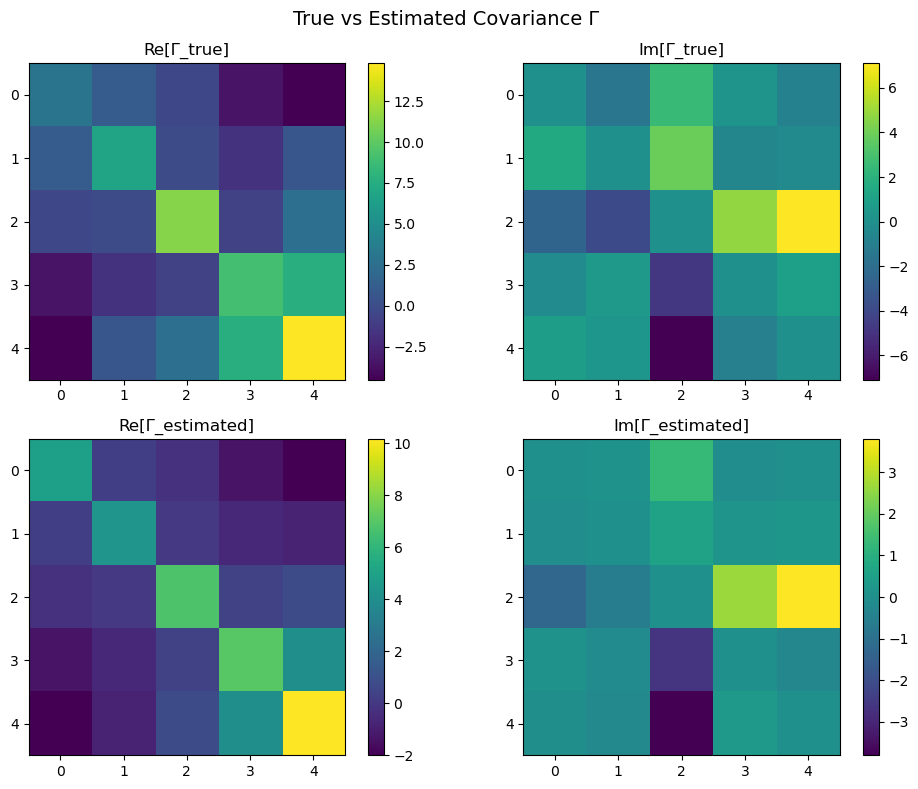

In [67]:
plot_complex_matrix_comparison(Gamma_true, Gamma_mean)

In [68]:
true_lambdas, _ = jnp.linalg.eigh(Gamma_true)
mean_lambdas, _ = jnp.linalg.eigh(Gamma_mean)

In [69]:
import matplotlib.pyplot as plt
import numpy as np

def plot_eigenvalue_mean(posterior_log_lambda, true_lambdas):
    """
    Plot the posterior mean of the eigenvalues on a log scale.
    """
    lambdas_mean = np.exp(posterior_log_lambda).mean(axis=0)

    plt.figure(figsize=(6, 4))
    plt.plot(np.sort(true_lambdas)[::-1], "o-", color='k')
    plt.plot(np.sort(lambdas_mean)[::-1], "o-")
    # plt.yscale("log")
    plt.xlabel("Index (sorted)")
    plt.ylabel("Posterior Mean Eigenvalue")
    plt.title("Posterior Mean of Eigenvalues (log scale)")
    plt.grid(True, which="both")
    plt.tight_layout()
    plt.show()


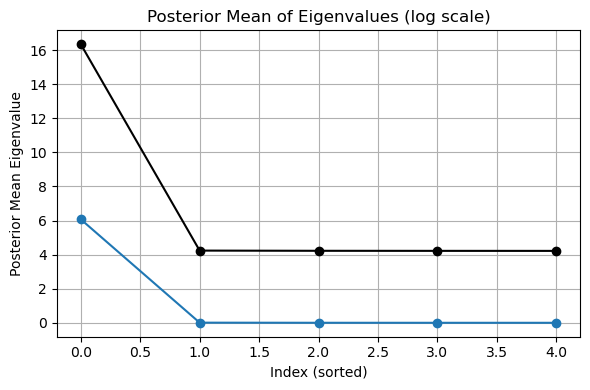

In [71]:
plot_eigenvalue_mean(posterior['log_lambda'], mean_lambdas)

In [ ]:
func(posterior[param_name])

Array([[0.2924258 , 1.2099845 , 4.4601693 ],
       [0.3135339 , 1.5144963 , 4.136565  ],
       [0.30246902, 1.6524634 , 4.21007   ],
       ...,
       [0.23286161, 1.5021538 , 4.1317396 ],
       [0.24552497, 1.2090564 , 3.7658548 ],
       [0.28857914, 1.1765733 , 3.9158733 ]], dtype=float32)